In [22]:
'''
Homework 5
Name: Austin Ramsey
ID: 000749074
LTU Honor Code: “I have neither given nor received any unauthorized aid in completing this work, nor have I presented someone else's work as my own.”

'''

"\nHomework 5\nName: Austin Ramsey\nID: 000749074\nLTU Honor Code: “I have neither given nor received any unauthorized aid in completing this work, nor have I presented someone else's work as my own.”\n\n"

In [23]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Feb 20 20:41:03 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P0    31W /  70W |   1736MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **Training a CNN from scratch on a small dataset (using Data Augmentation)**

Having to train an image classification model using only very little data is a common situation, which you likely encounter yourself in practice.

As a practical example, we will focus on 
classifying images as "dogs" or "cats", in a dataset.

## Methods to be applied
1. training a new model from scratch (This program)
2. data augmentation, a powerful technique for mitigating overfitting (This program)
3. doing feature extraction with a pre-trained network (2 methods), later
4. fine-tuning a pre-trained network, later


## Downloading the original cats & dogs data

The cats vs. dogs dataset that we will use isn't packaged with Keras. It was made available by Kaggle.com as part of a computer vision 
competition in late 2013, back when convnets weren't quite mainstream. You can download the original dataset at: 
`https://www.kaggle.com/c/dogs-vs-cats/data` (you will need to create a Kaggle account if you don't already have one -- don't worry, the 
process is painless).

The pictures are medium-resolution color JPEGs. They look like this:

<img src=https://s3.amazonaws.com/book.keras.io/img/ch5/cats_vs_dogs_samples.jpg width=650>

Unsurprisingly, the cats vs. dogs Kaggle competition in 2013 was won by entrants who used CNN. The best entries could achieve up to 
95% accuracy. This original dataset contains 25,000 images of dogs and cats (12,500 from each class) and is 543MB large (compressed). 


---


## Here, however, we are using much smaller dataset with only 4,000 (2K for train, 1K for validation, 1K for test) accessed from Chung's Google drive.

First click on the following link to access Chung's Google Drive folder:

[cats_dogs_sm](https://drive.google.com/drive/folders/1GfdXl6EHt3hiZv4bykEF-NGrMhEjncgz?usp=sharing)

1. Click on "cats_dogs_sm" folder. Then you will see a drop down menu
2. Select "Add shortcut to Drive". 
3. Then select "My Drive"
4. Click on "ADD shortcut" button. Now your Google drive has a shortcut to Chung's folder that has 4K dogs and cat images

If you are using LTU gmail account, you should be able to access the folder. If you are not using LTU gmail, then send cchung@ltu.edu an email. Then I will share the folder with you using your email address. These steps are important for this class for sharing data for future assignments.

## To access the datasets
<=== Click on the "folder" icon then click on the "Mount Drive". You will be also asked to run the following cell:

```
from google.colab import drive
drive.mount('/content/drive')
```

Check you see "cats_dogs_sm" folder.

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
# Directories
train_dir ='/content/drive/MyDrive/DL_data/cats_dogs_sm/train'
vali_dir = '/content/drive/MyDrive/DL_data/cats_dogs_sm/validation'
test_dir = '/content/drive/MyDrive/DL_data/cats_dogs_sm/test'

train_cats_dir ='/content/drive/MyDrive/DL_data/cats_dogs_sm/train/cats'
train_dogs_dir ='/content/drive/MyDrive/DL_data/cats_dogs_sm/train/dogs'
vali_cats_dir = '/content/drive/MyDrive/DL_data/cats_dogs_sm/validation/cats'
vali_dogs_dir = '/content/drive/MyDrive/DL_data/cats_dogs_sm/validation/dogs'
test_cats_dir = '/content/drive/MyDrive/DL_data/cats_dogs_sm/test/cats'
test_dogs_dir = '/content/drive/MyDrive/DL_data/cats_dogs_sm/test/dogs'

As a sanity check, let's count how many pictures we have in each training split (train/validation/test):

In [26]:
import os, shutil
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(vali_cats_dir)))
print('total validation dog images:', len(os.listdir(vali_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 500
total test dog images: 500



So we have indeed 2K training images, and then 1K validation and 1K test images. In each split, there is the same number of 
samples from each class: this is a balanced binary classification problem, which means that classification accuracy will be an appropriate 
measure of success.

## Building our network

* Since we are dealing with bigger images and a more complex problem (compared to the MNIST problem), we will make our network accordingly larger: it will have one 
more `Conv2D` + `MaxPooling2D` stage. 

* This serves both to augment the capacity of the network, and to further reduce the size of the feature maps, so that they aren't overly large when we reach the `Flatten` layer. Here, since we start from inputs of size 150x150 (a somewhat arbitrary choice), we end up with feature maps of size 7x7 right before the `Flatten` layer.

* Note that the depth (number) of the feature maps is progressively increasing in the network (from 32 to 128), while the size of the feature maps (response maps) is 
decreasing (from 148x148 to 7x7). This is a pattern that you will see in almost all CNNs.

* Since we are attacking a binary classification problem, we are ending the network with a single unit (a `Dense` layer of size 1) and a 
`sigmoid` activation. This unit will encode the probability that the network is looking at one class or the other.

In [33]:
from keras import layers
from keras import models
from keras import optimizers

def build_model():
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', 
                          input_shape=(150, 150, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Flatten())

  # Fraction of the input units to drop to fight overfitting
  model.add(layers.Dropout(0.1)) # float between 0~1 
                              
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4), # learning rate
              metrics=['acc'])
  return model

In [34]:
m = build_model()
m.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 17, 17, 128)     

Let's take a look at how the dimensions of the feature maps change with every successive layer:

For our compilation step, we'll go with the `RMSprop` optimizer as usual. Since we ended our network with a single sigmoid unit, we will 
use binary crossentropy as our loss. **For more info, please go to [this DLology page](https://www.dlology.com/blog/how-to-choose-last-layer-activation-and-loss-function/)**

## Data preprocessing

As you already know by now, data should be formatted into appropriately pre-processed floating point tensors before being fed into our 
network. Currently, our data sits on a drive as JPEG files, so the steps for getting it into our network are roughly:

* Read the picture files.
* Decode the JPEG content to RBG grids of pixels.
* Convert these into floating point tensors.
* Rescale the pixel values (between 0 and 255) to the [0, 1] interval (as you know, neural networks prefer to deal with small input values).

It may seem a bit daunting, but thankfully Keras has utilities to take care of these steps **automatically**. Keras has a module with image 
processing helper tools, located at `keras.preprocessing.image`. In particular, it contains the class `ImageDataGenerator` which allows to 
quickly set up Python generators that can automatically turn image files on disk into batches of pre-processed tensors.

https://vijayabhaskar96.medium.com/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720

Default **shuffle** value is True. shuffle = True for train and validation. False for test.

In [35]:
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        train_dir,              # This is the target directory
        target_size=(150, 150), # All images will be resized to 150x150
        batch_size=20,          # a batch with 20 images
        shuffle=True,           # default is True  
        class_mode='binary')    # Binary classification problem

vali_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = vali_datagen.flow_from_directory(
        vali_dir,
        target_size=(150, 150),
        batch_size=20,
        shuffle=True,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


As an **example** of using the train_generator, let's take a look at the output of one of these generators: it yields batches of 150x150 RGB images (shape `(20, 150, 150, 3)`) and binary 
labels (shape `(20,)`). 20 is the number of samples in each batch (the batch size). Note that the generator yields these batches 
*indefinitely*: it just loops endlessly over the images present in the target folder. For this reason, we need to `break` the iteration loop 
at some point.

In [36]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


In [31]:
#print(data_batch)

Let's fit (train) our model to the data.

It expects as first argument a Python generator that will yield batches of inputs and targets indefinitely. Because the data is being generated endlessly, the generator needs to know example how many samples to draw from the generator before 
declaring an epoch over. This is the role of the `steps_per_epoch` argument: after having drawn `steps_per_epoch` batches from the 
generator, i.e. after having run for `steps_per_epoch` gradient descent steps, the fitting process will go to the next epoch. In our case, 
batches are 20-sample large, so it will take 100 batches until we see our target of 2000 samples.

When you pass a generator as `validation_data` for validation, then 
this generator is expected to yield batches of validation data endlessly, and thus you should also specify the `validation_steps` argument, 
which tells the process how many batches to draw from the validation generator for evaluation.

In [37]:
model = build_model()
history = model.fit(
      train_generator,
      steps_per_epoch=100,     # 20 (batch_size) x 100 = 2,000 train samples
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50      # 20 (batch_size) x 50 = 1,000 validation samples
)

Epoch 1/30
100/100 [==============================] - 16s 152ms/step - loss: 0.6904 - acc: 0.5190 - val_loss: 0.6860 - val_acc: 0.5560
Epoch 2/30
100/100 [==============================] - 15s 148ms/step - loss: 0.6774 - acc: 0.5735 - val_loss: 0.6696 - val_acc: 0.5760
Epoch 3/30
100/100 [==============================] - 15s 147ms/step - loss: 0.6663 - acc: 0.5920 - val_loss: 0.6663 - val_acc: 0.5940
Epoch 4/30
100/100 [==============================] - 15s 147ms/step - loss: 0.6477 - acc: 0.6315 - val_loss: 0.6402 - val_acc: 0.6510
Epoch 5/30
100/100 [==============================] - 15s 149ms/step - loss: 0.6309 - acc: 0.6465 - val_loss: 0.6214 - val_acc: 0.6610
Epoch 6/30
100/100 [==============================] - 15s 148ms/step - loss: 0.6017 - acc: 0.6770 - val_loss: 0.5942 - val_acc: 0.6730
Epoch 7/30
100/100 [==============================] - 15s 148ms/step - loss: 0.5820 - acc: 0.6960 - val_loss: 0.6023 - val_acc: 0.6700
Epoch 8/30
100/100 [==============================] - 1

It is good practice to always save your models after training:

In [38]:
model.save('cats_and_dogs_small_1.h5') # saved in Google's VM. To be deleted within a day
model.save('/content/drive/MyDrive/DL_data/history_files/cats_and_dogs_small_1.h5') # saved on my gdrive
!ls '/content/drive/MyDrive/DL_data/history_files' # Google Colab server is on Linux

cats_and_dogs_small_1.h5


In [39]:
print(history.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


Let's plot the loss and accuracy of the model over the training and validation data during training:

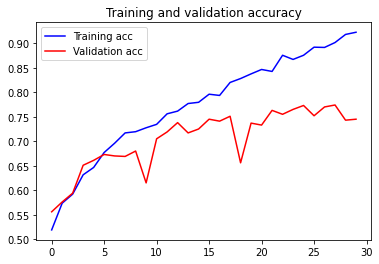

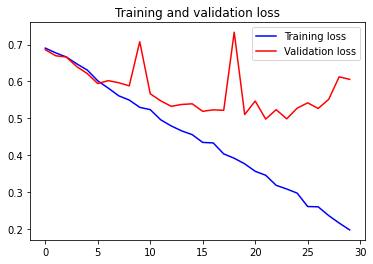

In [40]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

These plots are characteristic of overfitting...

Because we only have relatively few training samples (2000), overfitting is going to be our number one concern. To mitigate overfitting, we will be using:

- dropout - setting output of some neurons to zero
- weight decay (L2 regularization) - after each update, the weights are multiplied by a factor slightly less than 1. This prevents the weights from growing too large.
-  **data augmentation** - specific to computer vision, and used almost universally when processing images with deep learning models:

# **Using Data Augmentation (DA)**

* Overfitting is caused by having too few samples to learn from, rendering us unable to train a model able to generalize to new data. 
Given infinite data, our model would be exposed to every possible aspect of the data distribution at hand: we would never overfit. 

* Data augmentation takes the approach of generating more training data from existing training samples, by "augmenting" the samples via a number 
of random transformations that yield believable-looking images. **The goal is that at training time for each epoch, our model would never see the exact same 
image twice**. This helps the model get exposed to more aspects of the data and generalize better.

* In Keras, this can be done by configuring a number of random transformations to be performed on the images read by our `ImageDataGenerator` instance. 

In [41]:
datagen = ImageDataGenerator(     # No rescale here to just show
      rotation_range=60, # in degrees (0-180)
      width_shift_range=0.3,
      height_shift_range=0.3,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

These are just a few of the options available (for more, see the Keras documentation). Let's quickly go over what we just wrote:

* `rotation_range` is a value in degrees (0-180), a range within which to randomly rotate pictures.
* `width_shift` and `height_shift` are ranges (as a fraction of total width or height) within which to randomly translate pictures 
vertically or horizontally.
* `shear_range` is for randomly applying shearing transformations. [See this](http://scilabipcv.tritytech.com/2017/06/26/affine-transformation-shearing/)
* `zoom_range` is for randomly zooming inside pictures.
* `horizontal_flip` is for randomly flipping half of the images horizontally -- relevant when there are no assumptions of horizontal 
asymmetry (e.g. real-world pictures).
* `fill_mode` is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

Let's take a look at some of our augmented images:

/content/drive/MyDrive/DL_data/cats_dogs_sm/train/cats/cat.65.jpg
(150, 150, 3)
(1, 150, 150, 3)
(1, 150, 150, 3)


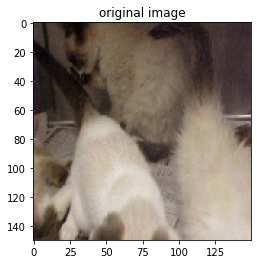

In [42]:
# This is module with image preprocessing utilities
import keras.utils as image

fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

# We pick one image to "augment"
img_path = fnames[3] # to choose one image to augment
print(img_path)
# Read the image and resize it
img = image.load_img(img_path, target_size=(150, 150))
plt.title('original image')
#plt.legend()
plt.imshow(img)
# Convert it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)
print(x.shape)
print((1,)+x.shape)
# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)
print(x.shape)

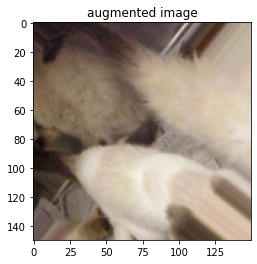

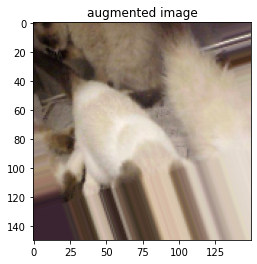

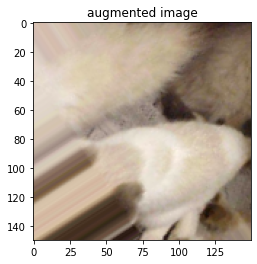

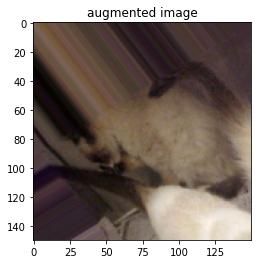

In [43]:
# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point.
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    plt.title('augmented image')
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i = i + 1
    if i > 3:
        break
plt.show()

If we train a new network using this data augmentation configuration, our network will never see twice the same input. However, the inputs 
that it sees are still heavily intercorrelated, since they come from a small number of original images -- we cannot produce new information, 
we can only remix existing information. As such, this might **not be quite enough to completely get rid of overfitting**. To further fight 
overfitting, we will also add a **Dropout** layer to our model, right before the densely-connected classifier:

Let's train our network using data augmentation and dropout:

In [45]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(     
        train_dir,               # This is the target directory
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        class_mode='binary')

# Note that the validation data should not be augmented!   
vali_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = vali_datagen.flow_from_directory(
        vali_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')    # must when loss=binary_crossentrophy

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [46]:
model_DA = build_model()
history = model_DA.fit(
      train_generator,      # never see same image, for each epoch
      steps_per_epoch=100,  # 20 x 100 = 2000 samples for an epoch
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)  # 20 (batch_size) x 50 = 1,000 validation samples

Epoch 1/30
100/100 [==============================] - 28s 273ms/step - loss: 0.6934 - acc: 0.5140 - val_loss: 0.6910 - val_acc: 0.5000
Epoch 2/30
100/100 [==============================] - 26s 256ms/step - loss: 0.6909 - acc: 0.5230 - val_loss: 0.6839 - val_acc: 0.5800
Epoch 3/30
100/100 [==============================] - 27s 266ms/step - loss: 0.6861 - acc: 0.5445 - val_loss: 0.6742 - val_acc: 0.5730
Epoch 4/30
100/100 [==============================] - 26s 261ms/step - loss: 0.6822 - acc: 0.5595 - val_loss: 0.6916 - val_acc: 0.5190
Epoch 5/30
100/100 [==============================] - 25s 247ms/step - loss: 0.6787 - acc: 0.5710 - val_loss: 0.6718 - val_acc: 0.5730
Epoch 6/30
100/100 [==============================] - 25s 248ms/step - loss: 0.6688 - acc: 0.5940 - val_loss: 0.6651 - val_acc: 0.5920
Epoch 7/30
100/100 [==============================] - 24s 244ms/step - loss: 0.6599 - acc: 0.6000 - val_loss: 0.6443 - val_acc: 0.6100
Epoch 8/30
100/100 [==============================] - 2

Let's save our model -- we will be using it in the section on CNN visualization. (Section 5.4)

In [47]:
model_DA.save('/content/drive/MyDrive/DL_data/history_files/cats_and_dogs_small_DA.h5')

Let's plot our results again:

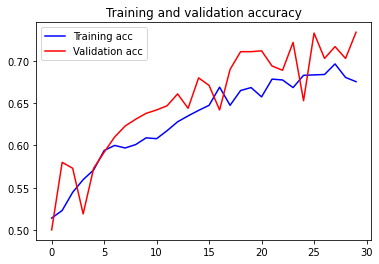

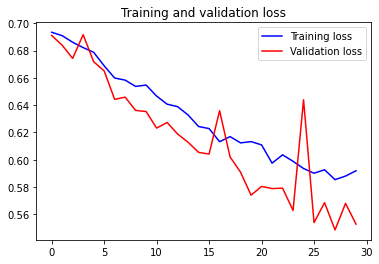

In [48]:
acc2 = history.history['acc']
val_acc2 = history.history['val_acc']
loss2 = history.history['loss']
val_loss2 = history.history['val_loss']

epochs = range(len(acc2))

plt.plot(epochs, acc2, 'b', label='Training acc')
plt.plot(epochs, val_acc2, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss2, 'b', label='Training loss')
plt.plot(epochs, val_loss2, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


Thanks to data augmentation and dropout, the training curves are rather closely tracking the validation curves. We have now better accuary, too.

Next step to improve our accuracy on this problem: using a pre-trained model next week.

## Evaluation: Display some Test images and present them to the model. Check the results

In [49]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory( # test_datagen - No DA
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        shuffle=True, # to display both cats and dogs
        class_mode='binary')

Found 1000 images belonging to 2 classes.


In [50]:
# To get the 1st batch from test dataset
for t_data_batch, t_labels_batch in test_generator:
    print('data batch shape:', t_data_batch.shape)
    print('labels batch shape:', t_labels_batch.shape)
    break # try this for loop without "break"

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


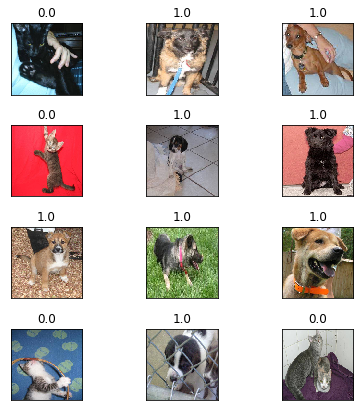

In [51]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
for i in range(12):
  plt.subplot(4,3,i+1)
  plt.tight_layout()
  plt.imshow(t_data_batch[i],interpolation='none')
  plt.title(f"{t_labels_batch[i]}")
  plt.xticks([])
  plt.yticks([])

In [52]:
print("target labels:     ", t_labels_batch)
# present the image to the network
out = model_DA.predict(t_data_batch, verbose=0) 
out = out.reshape(20,)
print("prediected labels: ", out.round())

target labels:      [0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0.]
prediected labels:  [1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0.]


In [53]:
# To get the 2nd batch
for t_data_batch, t_labels_batch in test_generator:
    print('data batch shape:', t_data_batch.shape)
    print('labels batch shape:', t_labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


In [54]:
print("target labels:     ", t_labels_batch)
# present the image to the network
out = model_DA.predict(t_data_batch) 
out = out.reshape(20,)
print("prediected labels: ", out.round())

target labels:      [1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1.]
1/1 [==============================] - 0s 24ms/step
prediected labels:  [1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1.]


## Evaluate 2 models
DA showed a little improvement here.

In [55]:
test_generator = test_datagen.flow_from_directory( # test_datagen - No DA
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        shuffle=False, # https://studymachinelearning.com/keras-imagedatagenerator-with-flow_from_directory/
        class_mode='binary')
test_loss, test_acc = model.evaluate(test_generator, steps = 50) # why 50? test_generator's batch size is 20 and we have 1000

Found 1000 images belonging to 2 classes.
50/50 [==============================] - 4s 86ms/step - loss: 0.6656 - acc: 0.7380


In [56]:
test_loss, test_acc = model_DA.evaluate(test_generator, steps = 50)

50/50 [==============================] - 5s 95ms/step - loss: 0.5666 - acc: 0.7080


##Self-Exercises
* Test this program with different DA parameters
* Experiment with Dropout(rate)
* Display only images that failed in the binary classification

# Summary

The CNN architecture that I changed was that I added an extra 2d convolutional layer and max pooling layer. As well, I changed the parameters for the data augmentation which included changing the rotation range to 60 degrees, the width shift range to 0.3, and the height shift range to 0.3 as well. Dropout was introduced as well. Overall, the effect from changing the model was not as I predicted, it ended up negatively effecting the model and bringing th eaccuracy lower. I think I may have changed the data augmentation too much, altering it differently may increase the accuracy more.